## Text Data and Recurring Neural Networks

In [1]:
source("src/lib.R")

In this notebook we'll summarise two related and important topics in Neural Networks:
* Text processing and how to feed text data into Neural Networks
* The Neural Networks models that have been developed to handle sequence data (i.e. text or timeseries)

### Text vectorization
In the previous notebooks we have seen that neural networks model must be fed with numeric tensors, the *text vectorization* is a process that transforms text data into quantitative data.

There are different way to *vectorize* text data, as example:
* Segment text into **words** and associate each word to a numerical vector.
* Segment text into **characters** and transform each character into a numerical vector.
* Extract **N-Grams** of words/characters and transform each N-Gram into a vector. A **N-gram** is a sequence of at most **N** consecutive words/characters in a text data: consider text *"UniCredit is a pan European Winner"*, it contains the following **3 grams**: *Unicredit, is, a, pan, European, Winner, Unicredit is, is a, a pan, pan European, European Winner, Unicredit is a, is a pan, a pan European, pan European Winner*.

In the following we'll focus our attention on the first *vectorization* strategy: **words** vectorization.

The **first step** in this process is to segment text data into words: *Tokenization*. Let's see how to tokenize text data in **KERAS**:

In [2]:
samples <- c("UniCredit is a pan European Winner", "CIB is fully plugged into UniCredit!")
tokenizer <- text_tokenizer() %>%
 fit_text_tokenizer(samples)

tokenizer$word_counts %>% names

[1] "unicredit" "is"        "a"         "pan"       "european"  "winner"   
 [7] "cib"       "fully"     "plugged"   "into"

The tokenizer found 10 different *words* in the input sentences. Note that the *tokenizer* makes also a normalization step: all the words (*tokens*) are lowercase and all the punctuaction marks have been removed. 

#### One-Hot encoding
The next step require to to associate each *token* to a numeric vector, the more simple way to do this is called **One-Hot encoding**.

This encoding strategy first requires to associate a unique integer index id $H_w$ to each word $w$. In **KERAS** this is done directly by the *tokenizer*:

In [3]:
tokenizer$word_index

$unicredit
[1] 1

$is
[1] 2

$a
[1] 3

$pan
[1] 4

$european
[1] 5

$winner
[1] 6

$cib
[1] 7

$fully
[1] 8

$plugged
[1] 9

$into
[1] 10

Then we need to transform our sample sentences into list of indices:

In [5]:
sequences <- texts_to_sequences(tokenizer, samples)
class(sequences)
length(sequences)

[1] "list"

[1] 2

The sequence associated with the first sentence, *UniCredit is a pan European Winner*, is:

In [6]:
sequences[[1]]

[1] 1 2 3 4 5 6

The sequence associated with *CIB is fully plugged into UniCredit* is:

In [7]:
sequences[[2]]

[1]  7  2  8  9 10  1

Note that the two words *UniCredit* (coded by **1**) and *is* (coded by **2**) are the only ones contained in both sentences, and as a consequence their codes are repeated in both sequences.

**Finally** we need to transform each number $H_w$ into a $N$-dimensional binary vector (where $N$ is the number of in unique tokens found by the tokenizer) such that the only not-zero component is the one corresponding to $H_w$. This final step is currently done by **KERAS** in a more smart way (as we'll see soon).  Here is a simple base *R* code to compute this final step:

In [8]:
results <- array(0, dim = c(
  length(sequences), # number of sentences
  max(sapply(sequences, length)), # maximum number of words in a sentence
  max(sapply(sequences, max)) # number of unique words in all sentences
))

for (i in 1:length(sequences)) {
  sequence <- sequences[[i]]
  for(h in 1:length(sequence)) {
    results[i, h, sequence[h]] <- 1
  }
}

The first sentences is **one-hot encoded** by:

In [9]:
results[1,,]

1,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0


And the second one by:

In [10]:
results[2,,]

0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0


#### Words Embedding

One-hot encoding is very simple and immediate but have a great disadvantage: the dimension of the vector it produces increases with $N$, the size of the considered vocabulary. Is not **BIG DATA** working with a vocabulary with thousands of words: in these cases we need a more **dense representation**.

The idea behind **words embedding** is to reduce the dimensionality of the binary sparse vectors produced by the **one-hot encoding** in to a more compact space of **numeric vectors**:

<img src="fig/words_embedding.PNG" width="400">

This mapping should preserve some semantic structure of the vocabulary it represents, in some way the geometric relationships between the embedded vectors should reflect the semantic relationships between the corresponding words. 

Otherwise, if we'd use a random mapping between words and numeric vector, any **neural network** couldn't be very effective since two words with a similar meanings like *handsome* and *attractive* could be mapped into very different vectors:  word embeddings are meant to
map human language into a geometric space (i.e. similar words should be "near"):

<img src="fig/words_plot.PNG" width="400">

How to find this type of mapping? There are mainly two ways:
* Use one of the words embedding mapping already computed by other people, like the [Word2Vec](http://code.google.com/archive/p/word2vec) or the [Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
* Learn the right embedding for your task while learning the rest of your model. 

#### Words embedding on IMDB dataset

In this notebook we'll see only how to find the right embedding while solving a text oriented task. But first we need a task!

Here we consider the [Internet Movie DataBase (IMDB)](https://www.imdb.com/) sentiment analysis dataset:

In [7]:
max_features <- 10000

imdb <- dataset_imdb(num_words = max_features)
x_train <- imdb$train$x
y_train <- imdb$train$y
x_test <- imdb$test$x
y_test <- imdb$test$y

This dataset is a sample dataset provided by **KERAS** and as a consequence has been already preprocessed:

In [12]:
x_train %>% class
x_train %>% length
x_train[[1]] %>% head(n = 5)
y_train[1]

[1] "list"

[1] 25000

[1]  1 14 22 16 43

[1] 1

The input features are the indexes associated with the words in a movie review, in the target binary class we have an indicator telling if the review is positive (1) or negative (0). Note that parameter *num_words* set to 10000 limits the considered dictionary to the 10000 words with the highest frequency in the IMDB reviews corpus. Using function **dataset_imdb_word_index** we can retrieve the original content of the review:

In [9]:
index_step <- 3  # word index offset
data <- dataset_imdb_word_index()
mapping_df <- data_frame(
  word = names(data),
  index = data %>% sapply(function(x)x[[1]]) + index_step
) %>% rbind(
  data_frame(
    word = c("<PAD>", "<START>","<UNK>"),
    index = 0:2
  )
)

x_train[[1]] %>% sapply(function(x) mapping_df %>% filter(index == x) %>% pull(word)) %>% paste(collapse = " ")
ifelse(y_train[1] == 1, "Positive", "Negative")
table(y_train)

[1] "<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

[1] "Positive"

y_train
    0     1 
12500 12500 

This review is a **positive** one, the grammar is not perfect because we are removing from each review the words that don't belong to the 10000 most frequent ones in the IMDB review corpus. Note that we are using a balanced training dataset! (and we are going to use accuracy to assess its performance!)

To further simplify the input dataset we consider only the first 20 words of each review: this simplification is done by function **pad_sequences** that also transform our sequences in matrix (or tensor) with one row for each review and one column for each word in the review. If the review has less than 20 words **pad_sequences** complete the sequence with the magic word < PAD >:

In [14]:
maxlen <- 20
mtx_train <- pad_sequences(x_train, maxlen = maxlen, truncating = "post", padding = "post")
mtx_test <- pad_sequences(x_test, maxlen = maxlen, truncating = "post", padding = "post")
class(x_train)
dim(x_train)
mtx_train[1,] %>% sapply(function(x) mapping_df %>% filter(index == x) %>% pull(word)) %>% paste(collapse = " ")                   

[1] "list"

NULL

[1] "<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you"

Now we are ready to learn our embedding while training a neural network on the imdb dataset:

In [21]:
model <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_features, output_dim = 8, input_length = maxlen) %>%
  layer_flatten() %>%
  layer_dense(units = 1, activation = "sigmoid")
model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("acc")
)
summary(model)
history <- model %>% fit(
  mtx_train, y_train,
  epochs = 10,
  batch_size = 32,
  validation_split = 0.2
)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
embedding_4 (Embedding)             (None, 20, 8)                   80000       
________________________________________________________________________________
flatten_2 (Flatten)                 (None, 160)                     0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 1)                       161         
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
________________________________________________________________________________


Here all the magic is done by the **layer_embedding** it takes in input our sequences of 20 *hot-encoded* words (i.e. a 10000-diimensional binary vector) and embeds each word into a 8-dimensional numeric vector: as a consequences this layer has (8 X 10000) parameters. After the **layer_embedding** we remove the bidimensional structure (20 X 8) of the data by stacking them into a 160-dimensional numeric vector. Finally we feed them to a standard classification layer.

Let's see the performance of this network:

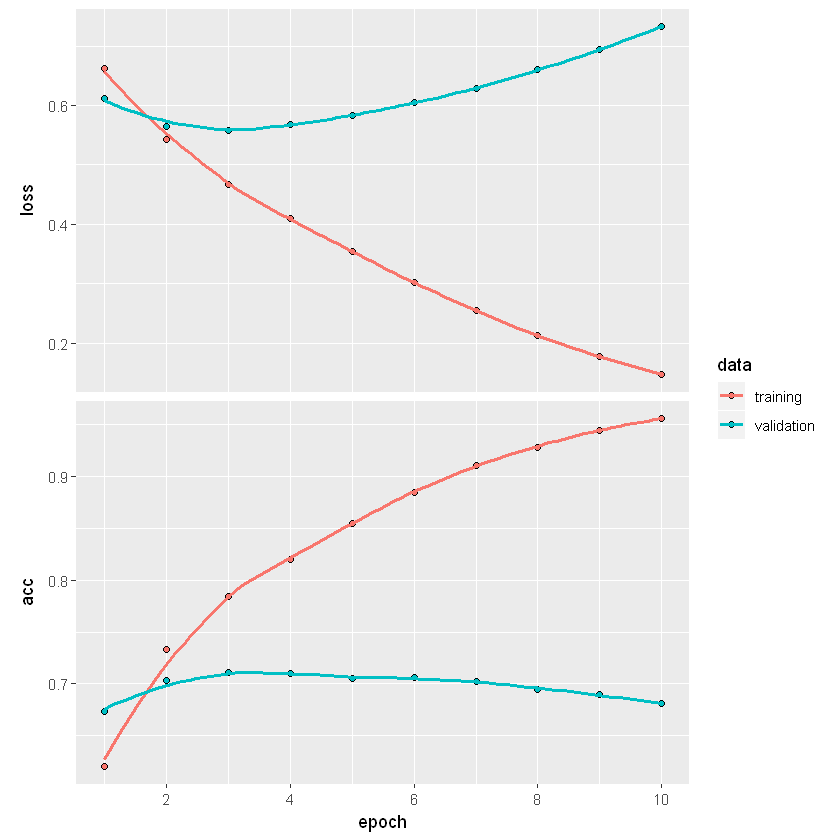

In [16]:
plot(history)

In [17]:
history$metrics$val_acc

[1] 0.6732 0.7032 0.7110 0.7102 0.7050 0.7060 0.7022 0.6944 0.6894 0.6808

An **accuracy** around 70% is not too bad considering we are using only 20 words for each review. Moreover the networks which we have seen so far do not takes into account the order of words and this order often contains important information for a text classification task.

Let's see how the embedding works by extracting the partial output of the network on the first two test reviews:

In [53]:
embedding_layer_name <- model$layers[[1]]$name
intermediate_layer_model <- keras_model(inputs = model$input,
                                        outputs = get_layer(model, embedding_layer_name)$output)

pred <- mtx_test[1:2,] %>% predict(intermediate_layer_model, .)

pred %>% class
pred %>% dim

[1] "array"

[1]  2 20  8

The first two words of each review are:

In [58]:
mtx_test[1, 1:3] %>% sapply(function(x) mapping_df %>% filter(index == x) %>% pull(word)) %>% paste(collapse = " ") 
mtx_test[2, 1:3] %>% sapply(function(x) mapping_df %>% filter(index == x) %>% pull(word)) %>% paste(collapse = " ") 

[1] "<START> please give"

[1] "<START> this film"

Words *give* and *film* are respectively embedded in vectors:

In [60]:
pred[1,2,]
pred[2,3,]

[1]  0.40864265 -0.36023232  0.38194218 -0.34835747  0.11402987  0.02386611
[7]  0.02433037  0.21595697

[1] -0.08313800 -0.01051528  0.06758078 -0.04765224  0.03972599 -0.03814527
[7]  0.15547705 -0.01623329

### Recurring Neural Networks

So far we have seen networks that are called **feed forward networks** in which the data flows in only one direction: from input towards output. This type of **network** cannot model directly sequence data: in order to pass the IMBD review to the final classification layer we had to pack a whole review into a single vector (dimension #words x #embedding_vector_size = 160).

However when we process a sequence (or a sentence) we process it step by step (or words by words), remembering the words we read (and eventually the decisions we made) in the past.

**A Recurrent Neural Network** tries to mimic this type of learning process by introducing a **LOOP** in the network:

<img src="fig/RNN.png" width="400">

A **RNN** processes a sequence *step by step* maintaining a **state** related to the piece of sequence it has seen so far. How does it do that? By feeding in input to the node at step **T** a *state* computed as the *output* produced by the **RNN** node at step **T-1**

<img src="fig/rnn_unrolled.png" width="800">

Note that the state is initialized at zero at the beginning of each sequence.

To use them in **KERAS** we just need to insert in our network a **layer_simple_rnn**. Let's see how this works on the **IMDB** dataset:

In [29]:
model <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_features, output_dim = 8) %>%
    layer_simple_rnn(units = 8) %>%
    layer_dense(units = 1, activation = "sigmoid")
    model %>% compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = c("acc")
)

history <- model %>% fit(
    mtx_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2
)

[1] 0.71

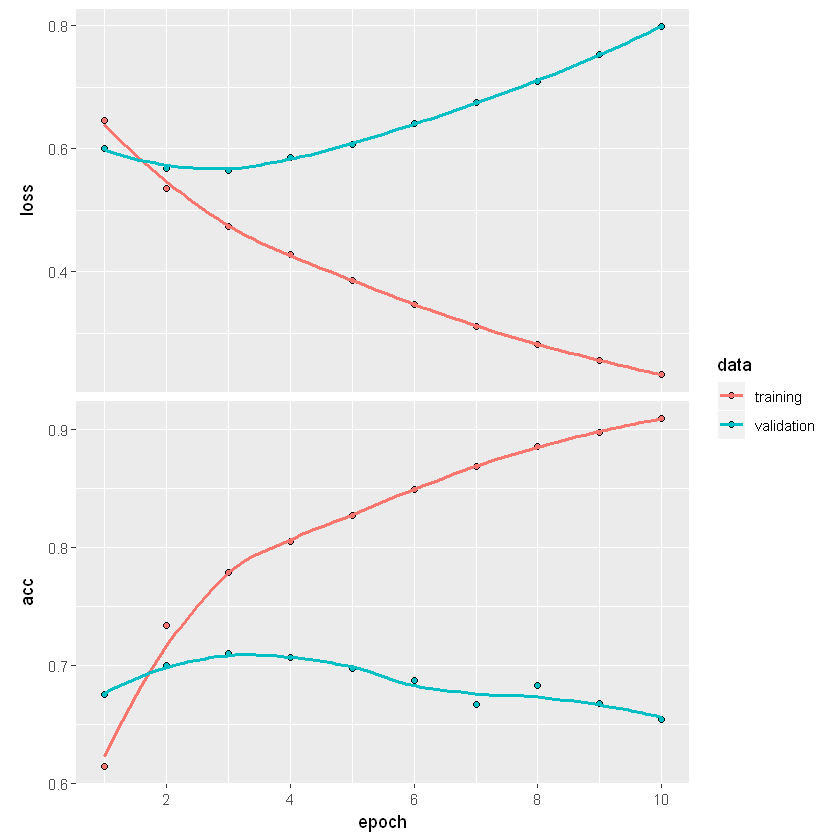

In [33]:
plot(history)
history$metrics$val_acc %>% max

Ooops...what's going on? It arrives at a 71% accuracy and then it deteriorates. why? The *simple recurring network* are too much simple: although it should theoretically be able to retain at time **T** all the information associated with data seen many timesteps before, in practice, such long-term dependencies are impossible to learn due to a mathematical problem call the *vanishing (or exploding) gradient problem*.

### Long Short Term Memory (LSTM)
The LSTM network is a way to overcome the difficulties caused by the *vanishing gradient problem* in the training of the simple *RNN* network

<img src="fig/lstm_unrolled.png" width="800">

Simple enough, w.r.t. to the simple RNN, **LSTM** adds a **Carry Track** that should help to transfer the information from the previous steps to the current steps. The information carried in this track is then used in the *output* activation function.

The complexity is hidden in the way in which the *carry* is computed. It involves three distinct transformations similar to the one computed to generate  the output in the simple RNN network.

*y = activation(dot(state_t, U) + dot(input_t, W) + b)*

But all three transformations have their own weight matrices *U*, *W* and *b*. The results of this transformation are used, along with the carry at time **T - 1**, to compute carry at time **T**. Abstractly these three transformations should mimic our *Long* and *Short* memory: but we are not neither *Daniel Kahneman* neither *Jürgen Schmidhuber*! 

So let's see how **LSTM** works on the IMDB problem using the **layer_lstm_network**:

In [35]:
model <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_features, output_dim = 8) %>%
    layer_lstm(units = 8) %>%
    layer_dense(units = 1, activation = "sigmoid")
    model %>% compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = c("acc")
)

history <- model %>% fit(
    mtx_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2
)

[1] 0.6848 0.7072 0.7172 0.7158 0.7144 0.7182 0.7158 0.7120 0.7102 0.7088

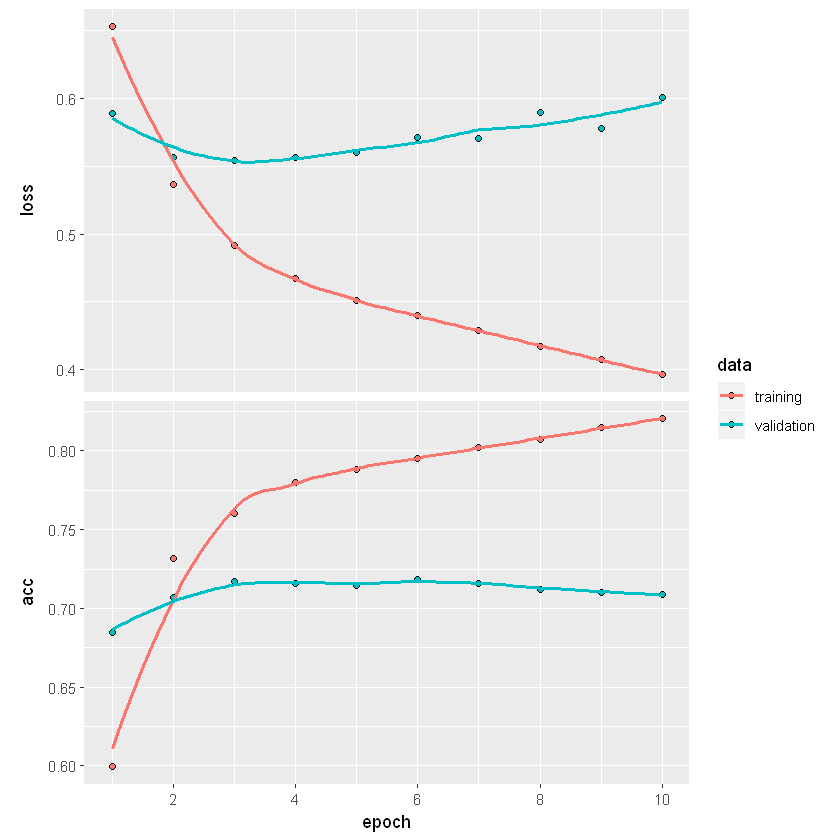

In [38]:
plot(history)
history$metrics$val_acc

Now the training process arrives over 71% and then stabilize! But the difference in performance between *LSTM* and simple *RNN* increases when the length of the sequences increases (Long Memory in action!). Let's what happens when we consider 100 words for each review in IMDB dataset.

In [10]:
maxlen <- 100
mtx_train <- pad_sequences(x_train, maxlen = maxlen, truncating = "post", padding = "post")
mtx_test <- pad_sequences(x_test, maxlen = maxlen, truncating = "post", padding = "post")

mtx_train[1,] %>% sapply(function(x) mapping_df %>% filter(index == x) %>% pull(word)) %>% paste(collapse = " ")                  

[1] "<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was"

In [ ]:
model <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_features, output_dim = 8) %>%
    layer_simple_rnn(units = 8) %>%
    layer_dense(units = 1, activation = "sigmoid")
    model %>% compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = c("acc")
)

history_rnn <- model %>% fit(
    mtx_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2
)

[1] 0.5190 0.5704 0.7036 0.7672 0.7624 0.7480 0.7468 0.7728 0.7536 0.7492

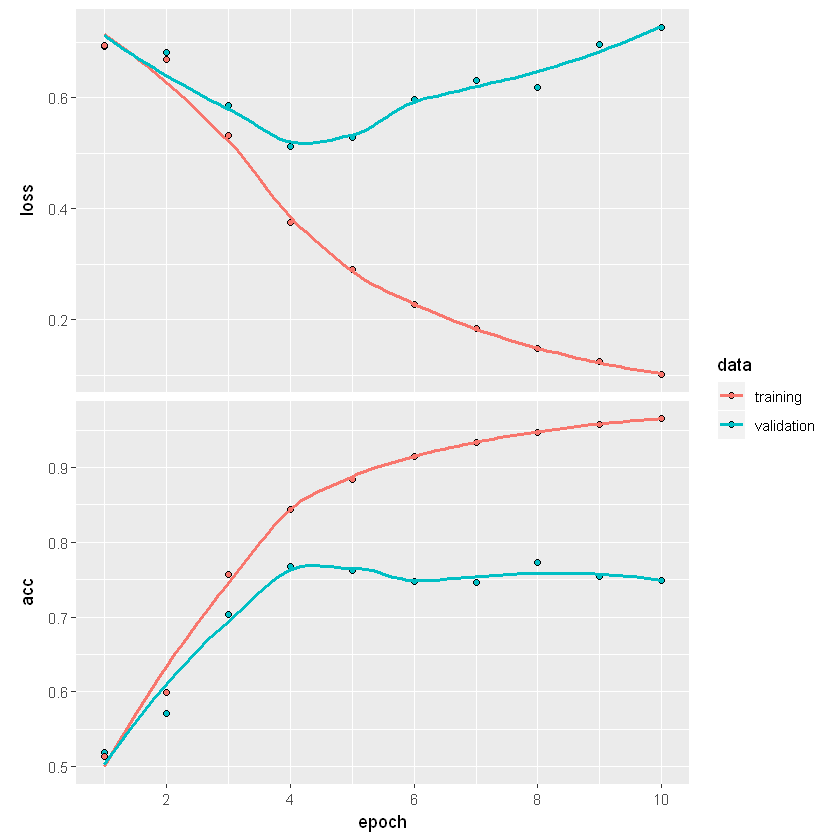

In [50]:
plot(history_rnn)
history_rnn$metrics$val_acc

In [47]:
model <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_features, output_dim = 8) %>%
    layer_lstm(units = 8) %>%
    layer_dense(units = 1, activation = "sigmoid")
    model %>% compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = c("acc")
)

history_lstm <- model %>% fit(
    mtx_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2
)

[1] 0.8060 0.8230 0.8218 0.8384 0.8352 0.8328 0.8372 0.8350 0.8272 0.8252

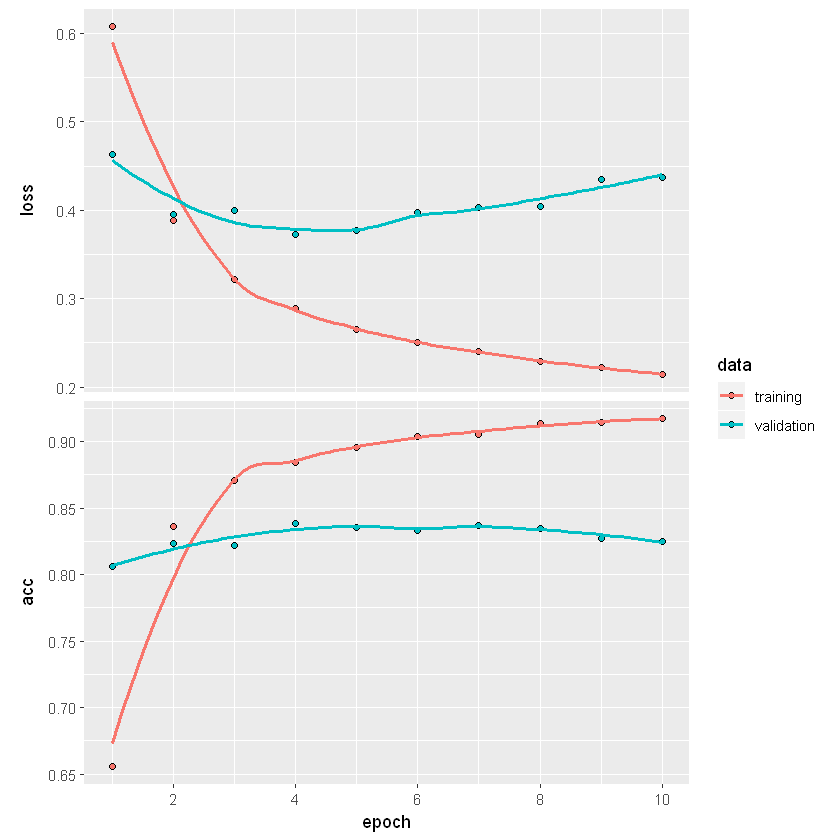

In [53]:
history_lstm$metrics$val_acc
plot(history_lstm)

Finally let's see what happens when using a *GRU*  (*Gated Recurrent Unit*) layer, that has performance similar to *LSTM* but with less parameters (more easy to train).

In [52]:
model <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_features, output_dim = 8) %>%
    layer_gru(units = 8) %>%
    layer_dense(units = 1, activation = "sigmoid")
    model %>% compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = c("acc")
)

history_gru <- model %>% fit(
    mtx_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2
)

[1] 0.7458 0.8192 0.8250 0.8368 0.8302 0.8344 0.8352 0.8336 0.8260 0.8274

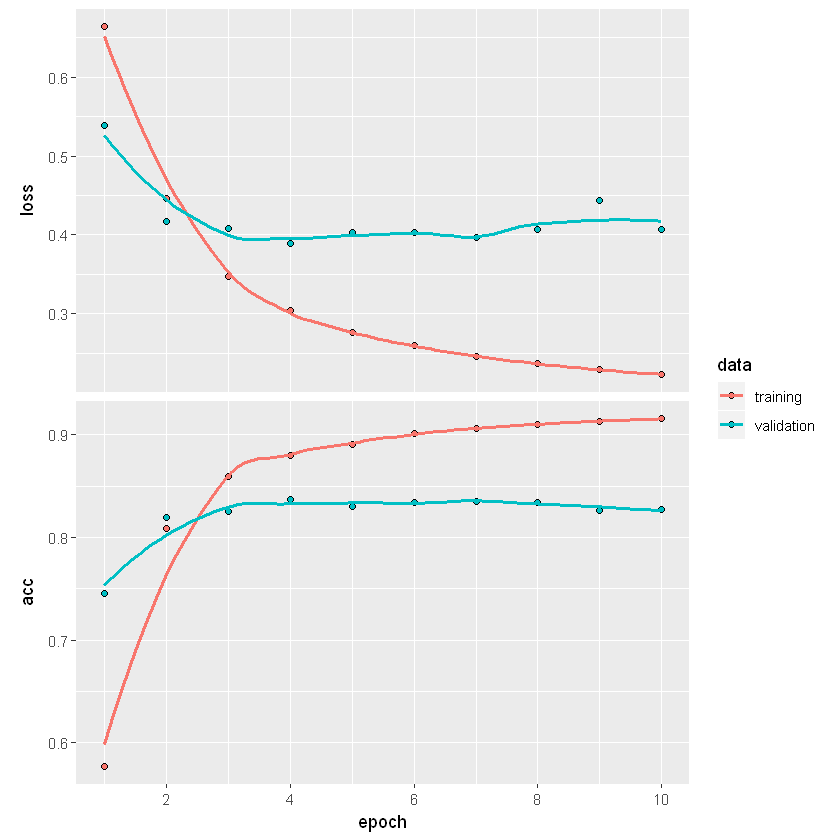

In [54]:
history_gru$metrics$val_acc
plot(history_gru)